# What Stats Lead to Learned League Wins?

Learned League (LL) is a daily online trivia contest that pits competitors against each other in one-on-one matchups. Everyone gets the same 6 questions, and in addition to answering them, competitors play defense by assigning how many points their opponent will get for each question if they get it right. The goal is to assign higher values to questions you think your opponent will get wrong, and lower values to the questions they will get right. The winner of a matchup is the one who scores more points (often whoever answers more questions right, but not always).

For the sake of competitive matchups, LL players are grouped into sub-leagues (called "Rundles") but skill level. 'A' Rundle is the highest (for absolute trivia monsters), down to 'E' at the lowest. Like in some European soccer leagues, players can get promoted to higher leagues or relegated to lower leagues at the end of the season based on their finish. I've spent my time in LL bouncing back and forth between D and E. There is also 'R' rundle for rookies, where there is generally a lot more variance as players of all levels are competing against each other. 

Since LL is matchup-based and has a defensive component, it is about more than just getting the most questions right. There is a skill to assigning defensive points, and definitely a lot of luck in terms of opponents' performance. My goal in this investigation is to use Machine Learning to determine which statistics are most important when it comes to winning at LL. 

**Questions**
1) Is it more important to answer the most questions right, play the best defense, or just to have an easy schedule? In other words, is it better to be lucky or good?

2) Do any other factors contribute significantly to LL performance?

**Project Plan**
1) Scrape LL's website to get a decent sample size of players' performances. I will be looking at individual players' "Stats" pages that show their overall stats for each season. The final column on this page is Rank, which shows where they finished within their rundle. That will serve as my target variable.

2) Use a regression model to predict a player's end of season rank using a variety of other statistics, then assess the weight of each statistic to see which ones matter most. 

## Scrape Player Data From LL

In [1]:
#import web scraping libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import json
#standard libraries
import pandas as pd
import numpy as np

In [2]:
#launch the driver, then send it to learned league
driver = webdriver.Chrome()
url = "https://learnedleague.com" 

# Open the webpage
driver.get(url)

# Wait for the toggle element to be clickable and click it to open the sidebar where I can enter login info
wait = WebDriverWait(driver, 10) 
toggle_button = wait.until(EC.element_to_be_clickable((By.CLASS_NAME, "toggle")))  
toggle_button.click()

#My credentials for LL, I'm pulling from a file saved locally. To anyone trying to recreate this code, use your 
#own credentials
path = "/Users/mhamburger94/ESH/Projects/adhoc/PD/ll_creds.json"
creds = json.load(open(path))['LL_creds']
username = creds['username']
password = creds['password']

# Wait for the username field in the sidebar to appear
username_field = wait.until(EC.presence_of_element_located((By.NAME, "username")))

# Locate and fill in the password field
password_field = driver.find_element(By.NAME, "password")
username_field.send_keys(username)
password_field.send_keys(password)

# Submit the form to log in
login_button = driver.find_element(By.CLASS_NAME, "button.primary") 
login_button.click()


In [3]:
#generate player id's. These are 4-5 digit numbers. Higher numbers correspond to newer players, so I'm capping 
#this at 69999 to focus on players who've been around longer, and thus have more seasons' worth of data
player_ids = np.random.randint(1000, 69999, size=500).tolist()


#start a dataframe df where the webdriver can deposit player data
df = pd.DataFrame(columns= ['Season', 'W', 'L', 'T', 'PTS', 'MPD', 'TMP', 'TCA', 'TPA', 'CAA', 'PCAA', 
                            'UfPA', 'DE', 'FW', 'FL', '3PT', 'MCW', 'QPct', 'Rundle', 'Rank'])

In [4]:
#initiate variable to count the number of valid profiles we find by cycling through the 500 random numbers
players_found = len(player_ids)

for id in player_ids:
    #put the player id in the url
    url = f"https://learnedleague.com/profiles.php?{id}&2"
    #go to that player's page
    driver.get(url)
    # Extract the page source after rendering
    html = driver.page_source

    # Parse the HTML with BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')

    # Locate the table with a summary of players' stats by season
    table = soup.find('table', {'class': 'std std_bord stats'})
    
    # Check if the table is found
    if table:
        # Convert the table to a DataFrame
        pp = pd.read_html(str(table))[0]
        df = pd.concat([df, pp], ignore_index=True)
    else:
        #if no player was found, reduce players_found by 1
        players_found = players_found - 1
#close the driver
driver.quit()

#get rid of the rows that summarize multiple seasons. I only want rows for individusal seasons
df = df[df['Season'].str.startswith('LL', na=False)].reset_index()

#how many of the random numbers I generated were active players' pages?
print(f"found data for {players_found} players")

found data for 147 players


In [5]:
df.head()

,index,Season,W,L,T,PTS,MPD,TMP,TCA,TPA,...,PCAA,UfPA,DE,FW,FL,3PT,MCW,QPct,Rundle,Rank
0,4,LL103,10,7,3,21,8,58,40,50,...,1.28,25,0.627,1,2,6,8,0.370,E Continental Div 2,11 (28)
1,5,LL102,8,14,3,19,-24,58,53,82,...,1.17,29,0.721,0,0,2,20,0.353,D Continental Div 2,22 (26)
2,6,LL101,14,7,4,32,29,76,57,47,...,1.12,24,0.700,2,0,8,18,0.380,E Continental Div 1,5 (30)
3,7,LL100,11,13,1,23,4,71,65,67,...,1.29,30,0.634,1,0,2,13,0.433,E Continental Div 2,16 (26)
4,8,LL97,9,12,4,21,-14,58,52,72,...,1.18,29,0.701,1,1,5,18,0.361,E Continental Div 2,17 (28)


In [6]:
df.shape

(3331, 21)

## Data Cleaning 

In [7]:
#Rank currently gives a player's finishing rank and also the size of their rundle. I want to clean that up to give
#one number, Performance, that quantifies how a player finished out of the size of their rundle. So 100% means
#a first place finish, and the percentage decreases as the Rank increases from there. 
df[['Finish', 'Rundle_Size']] = df['Rank'].str.extract(r'(\d+)\s*\((\d+)\)')

# Convert the new columns to integers
df['Finish'] = df['Finish'].astype(int)
df['Rundle_Size'] = df['Rundle_Size'].astype(int)
df['Performance'] = (df['Rundle_Size']-df['Finish']+1)/df['Rundle_Size']

#we just care about the rundle level, not the league name
df['Rundle']=df['Rundle'].str[0]

df.head()

,index,Season,W,L,T,PTS,MPD,TMP,TCA,TPA,...,FW,FL,3PT,MCW,QPct,Rundle,Rank,Finish,Rundle_Size,Performance
0,4,LL103,10,7,3,21,8,58,40,50,...,1,2,6,8,0.370,E,11 (28),11,28,0.642857
1,5,LL102,8,14,3,19,-24,58,53,82,...,0,0,2,20,0.353,D,22 (26),22,26,0.192308
2,6,LL101,14,7,4,32,29,76,57,47,...,2,0,8,18,0.380,E,5 (30),5,30,0.866667
3,7,LL100,11,13,1,23,4,71,65,67,...,1,0,2,13,0.433,E,16 (26),16,26,0.423077
4,8,LL97,9,12,4,21,-14,58,52,72,...,1,1,5,18,0.361,E,17 (28),17,28,0.428571


In [8]:
#check how many rows per rundle
df.groupby(by='Rundle').size()

Rundle
A    428
B    395
C    707
D    970
E    684
R    147
dtype: int64

## Run Regression analysis

**Plan**
1. Use a linear regression model to predict a player's performance based on the following stats: ['TCA', 'CAA', 'DE', 'FW', 'FL', '3PT']. Of the stats I imported, I'm not considering wins, losses, ties, or anything directly related to points. That's because I don't want a conclusion along the lines of "winning more games leads to a better finish" or "try scoring more points". Here are the meanings of those stats:
- TCA: Total Correct Answers 
- CAA: Correct Answers Allowed, or the number of total questions a player's opponents answered correctly. This is totally out of control of a player, and is a good measure of strength of schedule. 
- DE: Defensive Efficiency. This measures how well a player assigned defensive points based on their opponents' answers. It is a percentage, with 100% corresponding to perfect defense.
- FW: Forfeit Wins. 
- FL: Forfeit Losses
- 3PT: Number of 3-point questions answered correctly.

I expect TCA, CAA, and DE to have the most impact on overall performance, since they are the best measures of offensive skill (TCA), defensive skill (DE), and luck (CAA). The number of forfeits and 3 pointers are generally pretty low, so I don't expect to see them have much effect. 

2. Collect the model performance indicators (Mean Squared Error and R-squared) and feature weights.
3. See if the model is different when I separate it by rundle. 


In [9]:
#For ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Select features and target
features = ['TCA', 'CAA', 'DE', 'FW', 'FL', '3PT']
target = 'Performance'

#create subsets to allow for comparison
df_A = df[df['Rundle'] == 'A']
df_B = df[df['Rundle'] == 'B']
df_C = df[df['Rundle'] == 'C']
df_D = df[df['Rundle'] == 'D']
df_E = df[df['Rundle'] == 'E']
df_R = df[df['Rundle'] == 'R']

# Dictionary of data subsets, including the whole dataset
data_subsets = {
    'all': df,
    'A': df_A,
    'B': df_B,
    'C': df_C,
    'D': df_D,
    'E': df_E,
    'R': df_R
}

# Prepare an empty list to collect results
results = []

for subset_name, subset_df in data_subsets.items():
    
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(subset_df[features])
    y = subset_df[target]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Collect standardized coefficients
    coefficients = model.coef_

    # Store the results
    result_row = {
        'Rundle': subset_name,
        'MSE': mse,
        'R2': r2
    }
    result_row.update({f'Coef_{feature}': coef for feature, coef in zip(features, coefficients)})
    results.append(result_row)

    # Convert the results list to a DataFrame
Results = pd.DataFrame(results)

Results

,Rundle,MSE,R2,Coef_TCA,Coef_CAA,Coef_DE,Coef_FW,Coef_FL,Coef_3PT
0,all,0.018790,0.782746,0.303736,-0.363688,0.066542,0.003215,-0.010559,0.092681
1,A,0.026415,0.741128,0.211787,-0.135043,0.052587,-0.007894,-0.011670,0.074216
2,B,0.022397,0.792568,0.192920,-0.170815,0.070071,0.011363,-0.018389,0.078555
3,C,0.018839,0.761424,0.175020,-0.173512,0.072691,-0.005873,-0.008091,0.071325
4,D,0.016997,0.798083,0.176134,-0.143868,0.072389,0.007790,-0.016165,0.063888
5,E,0.016398,0.783750,0.171975,-0.111171,0.070029,0.002982,-0.004881,0.048795
6,R,0.005756,0.913028,0.154634,-0.083724,0.041256,0.005285,-0.015309,0.045741


Seeing MSE values around 0.01 to 0.02 and R2 values above 70%, I feel confident that the linear regression models are at least good enough for the purposes of this project. 

### Visualize and Analyze Regression Results 

In [10]:
#Prep data for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
# Take the absolute values of coefficient columns
coef_columns = [col for col in Results.columns if col.startswith('Coef_')]
Results[coef_columns] = Results[coef_columns].abs()
Results.rename(columns={'Coef_TCA': 'Total Correct Answers',
                        'Coef_CAA': 'Correct Answers Allowed',
                        'Coef_DE': 'Defensive Efficiency',
                        'Coef_FW': 'Forfeit Wins',
                        'Coef_FL': 'Forfeit Losses',
                        'Coef_3PT': '3 Pointers'}, inplace=True)


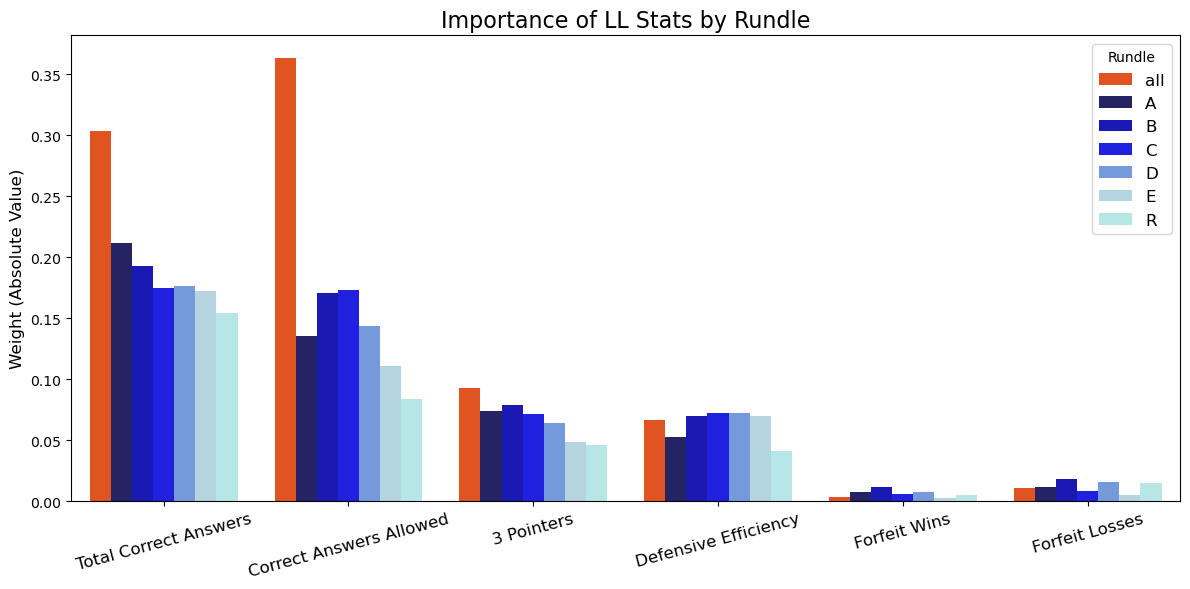

In [11]:
# Melt the Results DataFrame to long format for grouped bar plotting
plot_data = Results.melt(id_vars=['Rundle'], 
                         value_vars=Results[['Total Correct Answers',
                                     'Correct Answers Allowed',
                                        '3 Pointers',
                                     'Defensive Efficiency',
                                     'Forfeit Wins',
                                     'Forfeit Losses']], 
                         var_name='Coefficient', 
                         value_name='Weight')

# Create the grouped bar chart
plt.figure(figsize=(12, 6))
colors = {
    'all': 'orangered',  
    'A': 'midnightblue',   
    'B': 'mediumblue',
    'C': 'blue',
    'D': 'cornflowerblue',
    'E': 'lightblue',   
    'R': 'paleturquoise'    
}
sns.barplot(data=plot_data, x='Coefficient', y='Weight', hue='Rundle', palette=colors)

# Labels and such
plt.title('Importance of LL Stats by Rundle', fontsize=16)
plt.ylabel('Weight (Absolute Value)', fontsize=12)
plt.xlabel("")
plt.xticks(rotation=15, fontsize=12)
plt.legend(title='Rundle', loc='upper right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


## Takeaways

**1. Need to separate by rundle**

The graph above shows that CAA had a greater impact than TCA for the overall league, but for every individual rundle that trend was reversed. This is a Simpson's Paradox-esque case where we really shouldn't trust the overall trend because the meaning of any given number for TCA or CAA varies pretty drastically by rundle. 

Intuitively, this makes sense. If I told you I got 60 TCA for a LL season and asked you to predict my final rank, you would almost certainly ask "what rundle are you in?" before trying to answer. 60 would be a great performance in E rundle, but would get you relegated if you were in A. That leads me to believe that the orange bars above are less informative than the blues, and the fact that the MSE and R2 scores for the 'all' model were on par or worse than the individual rundles despite having a greater sample size backs that up. 

So here's the same graph with 'all' removed to see what factors were more and less important by rundle.


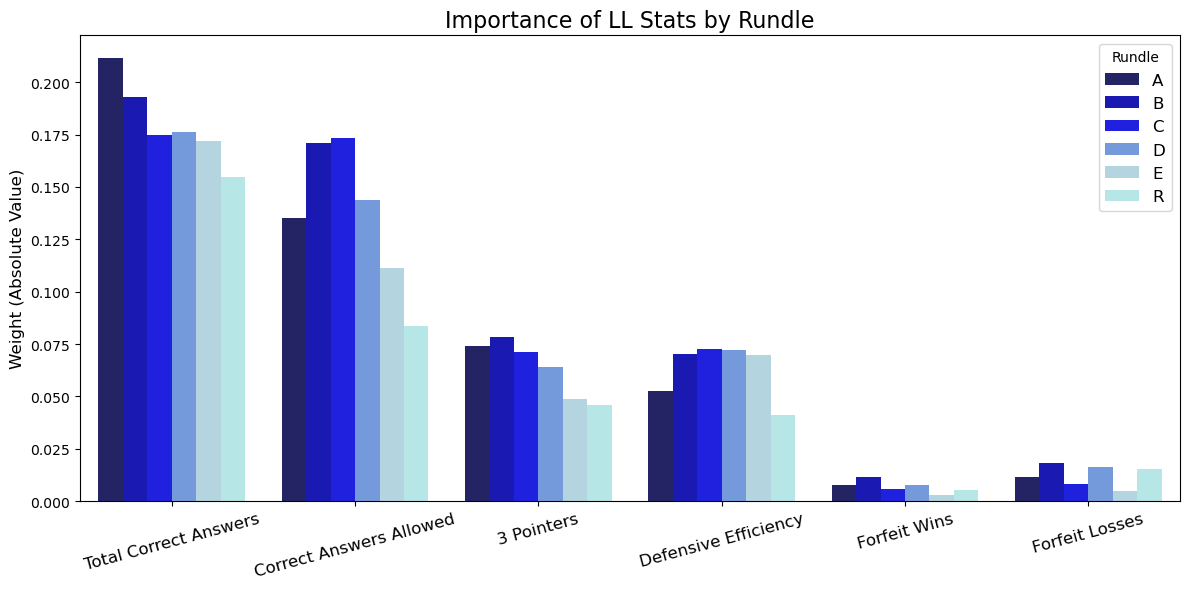

In [12]:
# Remove the bars for 'All' from the plotting data
no_all_bars = plot_data[plot_data['Rundle'] != 'all']

# Create the grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=no_all_bars, x='Coefficient', y='Weight', hue='Rundle', palette=colors)

# Labels and such
plt.title('Importance of LL Stats by Rundle', fontsize=16)
plt.ylabel('Weight (Absolute Value)', fontsize=12)
plt.xlabel("")
plt.xticks(rotation=15, fontsize=12)
plt.legend(title='Rundle', loc='upper right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

**2. Luck vs. Skill**

In every individual rundle, TCA outweighed CAA. It was relatively close in B and C rundles, but there was a significant difference in E (0.17 vs. 0.11) and even more so in R (0.15 vs. 0.08). I was surprised to see this split in A resemble E and R more than B and C. I interpret this as saying that getting relatively more questions right is a better separator when some players are truly elite (i.e. in A rundle) or when some players really stink (i.e. E and R). But when there is more parity in B and C, it's harder to stand out with just high TCA, so having an easier schedule (high CAA) becomes more important. 

I was surprised to see 3 Pointers were about on par with DE, but upon reflection that makes sense. Getting the 3 point question right is sort of like "offensive efficiency" (a stat that LL does track in the "expanded standings", but I couldn't find a way to include that in the web scraping). And for both stats, the importance of efficiency went up as the competition gets stiffer. So as more people are answering more questions correctly, it becomes more important to answer and correctly defend the important questions. 

*So what's more important: being lucky or good?* 

Turns out they're about the same, with a slight edge towards being good that increases as competition gets weaker. 

**3. Impact of Forfeits**

I expected to see forfeit wins and losses by relatively small in weight, but have more of an impact in E and R where people tend to take LL less seriously and forfeit more often. That was close to what I observed, except there wasn't much of a spike in E and R, so I'll chalk that up to forfeits generally not being a good predictor of overall success. The two main rules of LL are "Don't cheat" and "Don't forfeit"; I think FW and FL's relatively small bars indicate that people are generally following the second rule. Whether or not they are cheating is out of scope for this project. 